In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from dotenv import load_dotenv
import requests
from datetime import timedelta
import json

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import numpy as np


In [3]:
import cpi


In [4]:
load_dotenv("../../.env",override=True)
pd.set_option("display.max_columns",500)

In [5]:
college = cpi.series.get(items='College tuition and fees',periodicity='Monthly').to_dataframe().sort_values(by='date')
housing = cpi.series.get(items='Housing',periodicity='Monthly').to_dataframe().sort_values(by='date')
allItems = cpi.series.get(items='All items',periodicity='Monthly').to_dataframe().sort_values(by='date')
energy = cpi.series.get(items='Energy',periodicity='Monthly').to_dataframe().sort_values(by='date')
food = cpi.series.get(items='Food',periodicity='Monthly').to_dataframe().sort_values(by='date')
medicalCare = cpi.series.get(items='Medical care',periodicity='Monthly').to_dataframe().sort_values(by='date')
recreation = cpi.series.get(items='Recreation',periodicity='Monthly').to_dataframe().sort_values(by='date')
rent = cpi.series.get(items='Rent of primary residence',periodicity='Monthly').to_dataframe().sort_values(by='date')
healthInsurance = cpi.series.get(items='Health insurance',periodicity='Monthly').to_dataframe().sort_values(by='date')


series = {
    'college':college,
    'housing':housing,
    'allItems':allItems,
    'energy':energy,
    'food':food,
    'medicalCare':medicalCare,
    'recreation':recreation,
    'rent':rent,
    'healthInsurance':healthInsurance,
}

for k in series.keys():
    series[k] = series[k][series[k]['period_type']=='monthly'][['year','date','value','series_id','series_items_name']].copy()
    series[k]['inflation'] = series[k]['value']/series[k]['value'].shift(12) - 1
    series[k].index = pd.to_datetime(series[k]['date']).values

allDat = pd.concat(list(series.values()))
allDat['date']=allDat['date'].astype(str)

inflation_cross = pd.crosstab(index = allDat['date'],
    columns = allDat['series_items_name'],
    values = allDat['inflation'],
    aggfunc='mean')

cpi_cross = pd.crosstab(index = allDat['date'],
    columns = allDat['series_items_name'],
    values = allDat['value'],
    aggfunc='mean')

    
cpi_cross['month'] = cpi_cross.index
cpi_cross['month']=cpi_cross['month'].astype(str)
cpi_cross['inflation']=cpi_cross['All items']/cpi_cross['All items'].shift(12) - 1


In [6]:
cpi_cross

series_items_name,All items,College tuition and fees,Energy,Food,Health insurance,Housing,Medical care,Recreation,Rent of primary residence
date,,,,,,,,,
1913-01-01,9.800,NaN,NaN,9.700,NaN,NaN,NaN,NaN,NaN
1913-02-01,9.800,NaN,NaN,9.600,NaN,NaN,NaN,NaN,NaN
1913-03-01,9.800,NaN,NaN,9.600,NaN,NaN,NaN,NaN,NaN
1913-04-01,9.800,NaN,NaN,9.700,NaN,NaN,NaN,NaN,NaN
1913-05-01,9.700,NaN,NaN,9.600,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-04-01,289.109,895.552,298.469,298.711,191.433,295.259,541.515,129.892,362.951
2022-05-01,292.296,895.552,316.761,302.038,195.213,297.868,543.488,130.360,365.116
2022-06-01,296.311,898.003,340.917,305.041,199.279,300.927,546.717,130.677,367.927


In [7]:
consumerKey = os.environ.get("CONSUMER_KEY")


In [8]:
url = "https://api.tdameritrade.com/v1/marketdata/$SPX.X/pricehistory?periodType=year&period=20&frequencyType=weekly&frequency=1"
response = requests.get(url,
        params={'apikey' : consumerKey})
SPY = pd.DataFrame(json.loads(response.content)['candles'])
SPY['date'] = pd.to_datetime(SPY['datetime'],unit='ms').dt.date
SPY.index = SPY['date'].values

SPY['month'] = pd.to_datetime(SPY['date']) - pd.to_timedelta(pd.to_datetime(SPY['date']).dt.day-1,unit='d')
SPY['month'] = SPY['month'].astype(str)

In [21]:
PE_history = pd.read_html("https://www.multpl.com/s-p-500-pe-ratio/table/by-month")
PE_history = PE_history[0]
PE_history.columns = ['month','sp500 pe']
PE_history['sp500 pe'] = PE_history['sp500 pe'].str.replace(' estimate','').astype(float)
PE_history['month'] = pd.to_datetime(PE_history['month']).astype(str)
PE_history.index = pd.to_datetime(PE_history['month']).values

(array([ 1826.,  3652.,  5479.,  7305.,  9131., 10957., 12784., 14610.,
        16436., 18262., 20089.]),
 [Text(1826.0, 0, '1975'),
  Text(3652.0, 0, '1980'),
  Text(5479.0, 0, '1985'),
  Text(7305.0, 0, '1990'),
  Text(9131.0, 0, '1995'),
  Text(10957.0, 0, '2000'),
  Text(12784.0, 0, '2005'),
  Text(14610.0, 0, '2010'),
  Text(16436.0, 0, '2015'),
  Text(18262.0, 0, '2020'),
  Text(20089.0, 0, '2025')])

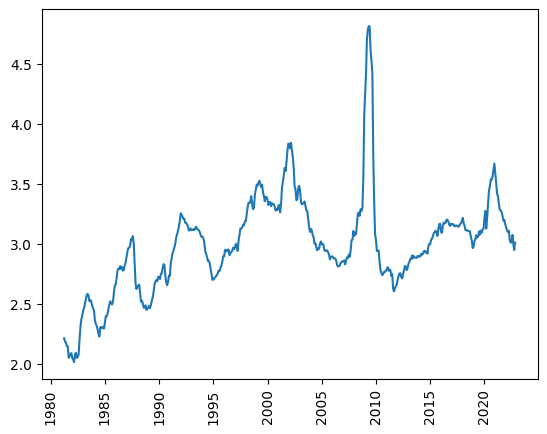

In [27]:
plt.plot(np.log(PE_history['sp500 pe'].head(500)))
plt.xticks(rotation=90)

In [28]:
spy_pe_hist = SPY.merge(PE_history,left_on=['month'],right_on=['month'],how='left')
spy_pe_hist = spy_pe_hist.merge(cpi_cross[['month','inflation','All items']],on='month',how='left')
spy_pe_hist.index = pd.to_datetime(spy_pe_hist['date']).values

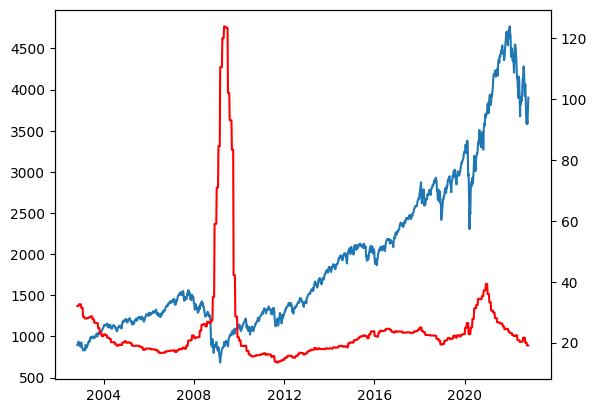

In [29]:
fix,ax1 = plt.subplots()
ax1.plot(spy_pe_hist['close'])
ax2 = ax1.twinx()
ax2.plot(spy_pe_hist['sp500 pe'],color='red')

In [30]:
spy_pe_hist['All items'].fillna(spy_pe_hist[~spy_pe_hist['All items'].isna()]['All items'].values[-1],
    inplace=True)
spy_pe_hist['inflation'].fillna(spy_pe_hist[~spy_pe_hist['inflation'].isna()]['inflation'].values[-1],
    inplace=True)


In [31]:
spy_pe_hist['close_yoy_change']=spy_pe_hist['close'].shift(-52)/spy_pe_hist['close']
spy_pe_hist['masked sp500 pe'] = np.where(spy_pe_hist['sp500 pe'] > 40,40,spy_pe_hist['sp500 pe'] )
spy_pe_hist['int1'] = spy_pe_hist['masked sp500 pe']*spy_pe_hist['All items']

In [32]:
s2 = spy_pe_hist.dropna().copy()

In [70]:
feats = ['masked sp500 pe','All items','inflation']
kpi = 'close_yoy_change'

X, y = s2[feats],s2[kpi]

X_train,X_test,y_train,y_test =  train_test_split(
    X, y, test_size=.05, random_state=42,shuffle=False)

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor


pipe = Pipeline(
    steps = [
    #('scaler',MinMaxScaler()),
    ('XGB',XGBRegressor(max_depth=3,n_estimators=50,random_state=42))
   # ('LR',LinearRegression())
    ]
)

pipe.fit(X_train,y_train)

Pipeline(steps=[('XGB',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=3, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=50, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=42, reg_alpha=0,
                              reg_lambda=1, ...))])

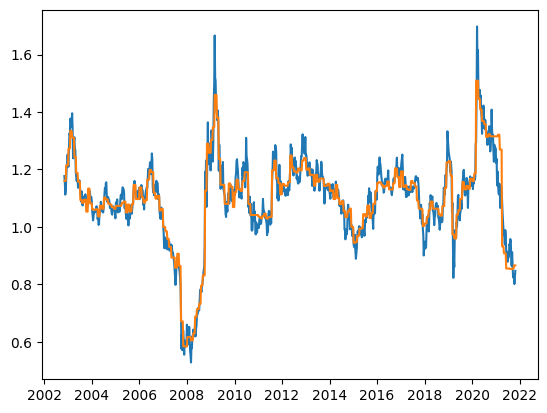

In [78]:
pred = pipe.predict(s2[feats])

s2['pred'] = pred

plt.plot(s2[kpi])
plt.plot(s2['pred'])

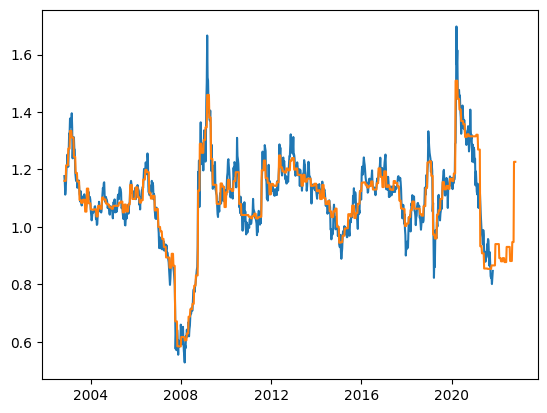

In [79]:
pred = pipe.predict(spy_pe_hist[feats])

spy_pe_hist['pred'] = pred

plt.plot(spy_pe_hist[kpi])
plt.plot(spy_pe_hist['pred'])

In [80]:
spy_pe_hist

,open,high,low,close,volume,datetime,date,month,sp500 pe,inflation,All items,close_yoy_change,masked sp500 pe,int1,pred
2002-11-04,900.96002,925.65997,891.62000,894.72998,0,1036389600000,2002-11-04,2002-11-01,32.03,0.021984,181.300,1.177126,32.03,5807.03900,1.160316
2002-11-11,894.73999,910.21002,872.04999,909.73999,0,1036994400000,2002-11-11,2002-11-01,32.03,0.021984,181.300,1.154561,32.03,5807.03900,1.160316
2002-11-18,909.83002,937.28003,893.09003,930.54999,0,1037599200000,2002-11-18,2002-11-01,32.03,0.021984,181.300,1.112546,32.03,5807.03900,1.160316
2002-11-25,930.54999,941.82001,912.09998,936.31000,0,1038204000000,2002-11-25,2002-11-01,32.03,0.021984,181.300,1.130181,32.03,5807.03900,1.160316
2002-12-02,936.31000,954.28003,895.96002,912.22998,0,1038808800000,2002-12-02,2002-12-01,32.59,0.023769,180.900,1.163632,32.59,5895.53100,1.214496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,3682.72000,3736.74000,3584.13000,3585.62000,0,1664168400000,2022-09-26,2022-09-01,20.03,0.082627,296.171,NaN,20.03,5932.30513,0.947463
2022-10-03,3609.78000,3806.91000,3604.93000,3639.66000,0,1664773200000,2022-10-03,2022-10-01,19.08,0.082627,296.171,NaN,19.08,5650.94268,1.226671
2022-10-10,3647.51000,3712.00000,3491.58000,3583.07000,0,1665378000000,2022-10-10,2022-10-01,19.08,0.082627,296.171,NaN,19.08,5650.94268,1.226671
2022-10-17,3638.65000,3762.79000,3638.65000,3752.75000,0,1665982800000,2022-10-17,2022-10-01,19.08,0.082627,296.171,NaN,19.08,5650.94268,1.226671


In [81]:
import shap
explainer = shap.Explainer(pipe['XGB'])
#shap_values = explainer(pd.DataFrame(MinMaxScaler().fit_transform(spy_pe_hist[feats]),columns=feats))
shap_values = explainer(spy_pe_hist[feats])




ntree_limit is deprecated, use `iteration_range` or model slicing instead.


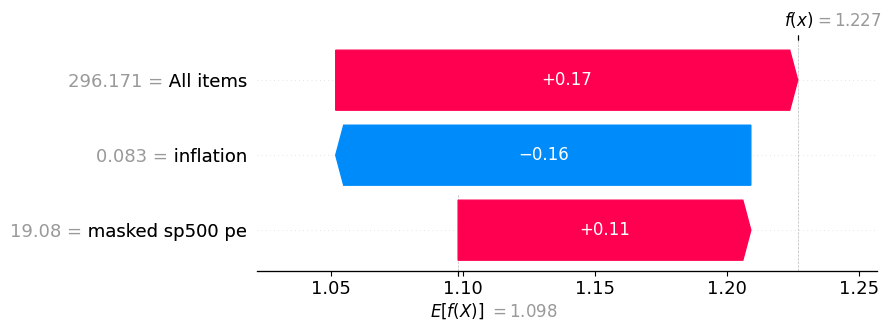

In [82]:

shap.plots.waterfall(shap_values[1042])

In [55]:
len(spy_pe_hist)

1043